# Load data

In [1]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()


sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df


# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


In [2]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()
sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']

# Read weights.txt helper
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# Load healthy weights
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Collect all sample data into a flat DataFrame
rows = []

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    weight_file = folder / "weights.txt"
    current_weights = read_weights(weight_file) if weight_file.exists() else {}

    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            # Load data
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

            # Delta weight
            delta_weight = current_weights.get(sample_file, None)
            if sample_file in healthy_weights and delta_weight is not None:
                delta_weight -= healthy_weights.get(sample_file, 0.0)

            # Store each row with metadata
            for _, row in df.iterrows():
                row_data = row.to_dict()
                row_data['folder'] = folder_name
                row_data['sample_file'] = sample_file
                row_data['delta_weight'] = delta_weight
                rows.append(row_data)

# Final DataFrame for easy analysis
combined_data = pd.DataFrame(rows)


In [3]:
def get_sample_data(folder_name, sample_file):
    """
    Returns a DataFrame for a specific folder and sample,
    including the delta weight as a column.
    """
    df = combined_data[
        (combined_data['folder'] == folder_name) &
        (combined_data['sample_file'] == sample_file)
    ].copy()
    
    # Optionally, add a single value column for delta_weight if you want it separate
    if not df.empty:
        df['delta_weight'] = df['delta_weight'].iloc[0]
    
    return df


# PLOT DATA

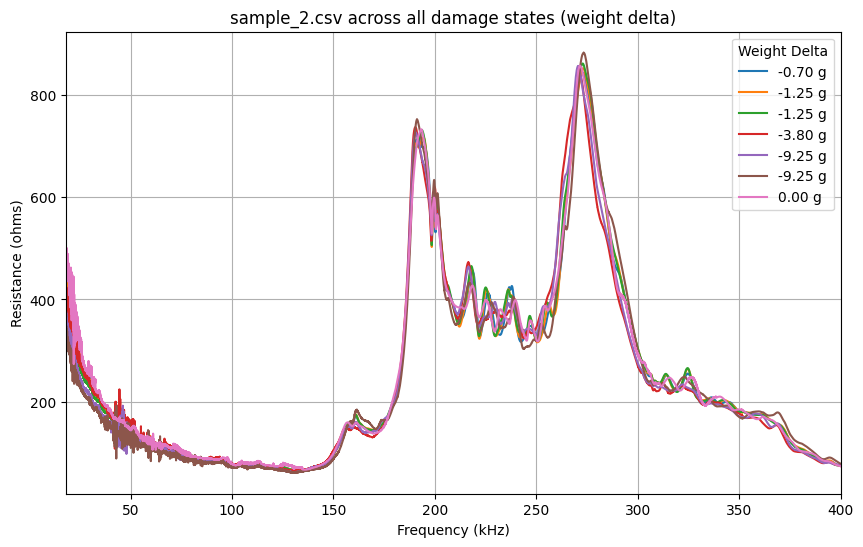

In [ ]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_2.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Resistance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Resistance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()



# RMSD function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rmsd_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Resistance (ohms)"].values[mask])

    rmsd_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Resistance (ohms)"].values[mask])
        rmsd = np.sqrt(np.mean((Z - Z_ref) ** 2))
        rmsd_list.append(rmsd)
        plt.plot(freqs_kHz, Z, label=str(label[i]))


    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Resistance")
    plt.title("Normalized Resistance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(rmsd_list)


## Test RMSD

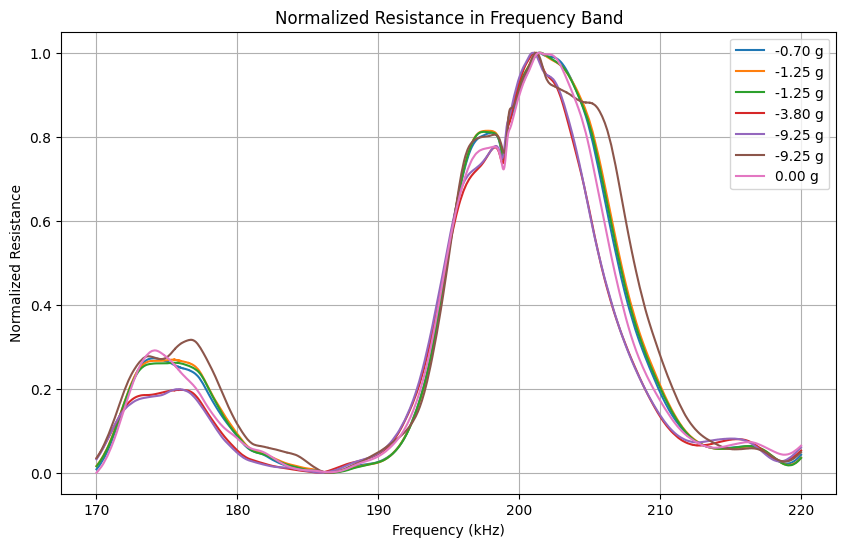

[0.02173932 0.03152481 0.02768094 0.04741285 0.04808134 0.07457356
 0.        ]


In [ ]:
sample_to_plot = "sample_1.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(rmsd_values)

# CCD Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_corr_dev_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Resistance (ohms)"].values[mask])

    corr_dev_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Resistance (ohms)"].values[mask])
        corr_coef = np.corrcoef(Z, Z_ref)[0, 1]  # Pearson correlation coefficient
        corr_dev = 1 - corr_coef
        corr_dev_list.append(corr_dev)
        plt.plot(freqs_kHz, Z, label=str(label[i]))

    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Resistance")
    plt.title("Normalized Resistance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(corr_dev_list)

## Test CCD Function

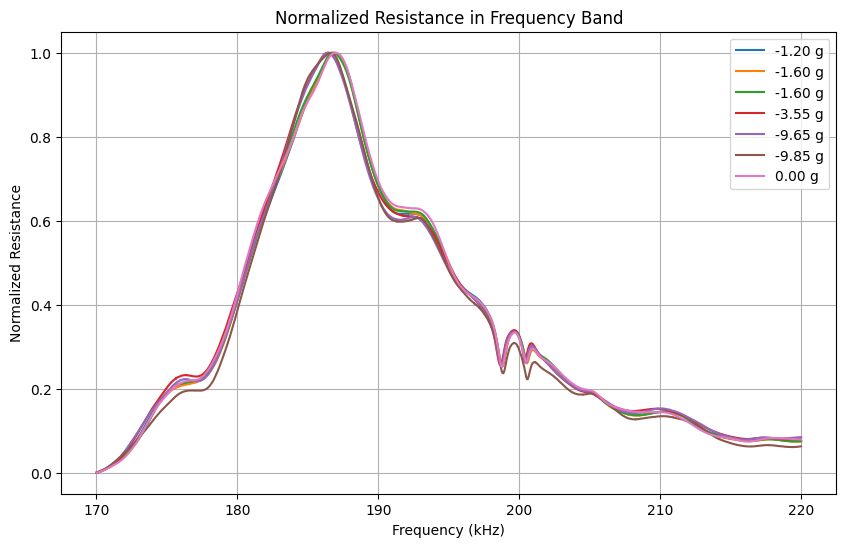

[3.58512397e-04 2.98855714e-04 3.75946416e-04 2.05212775e-03
 2.27481207e-03 2.59802349e-03 2.22044605e-16]


In [ ]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(CCD_values)

# Get RMSD and CCD

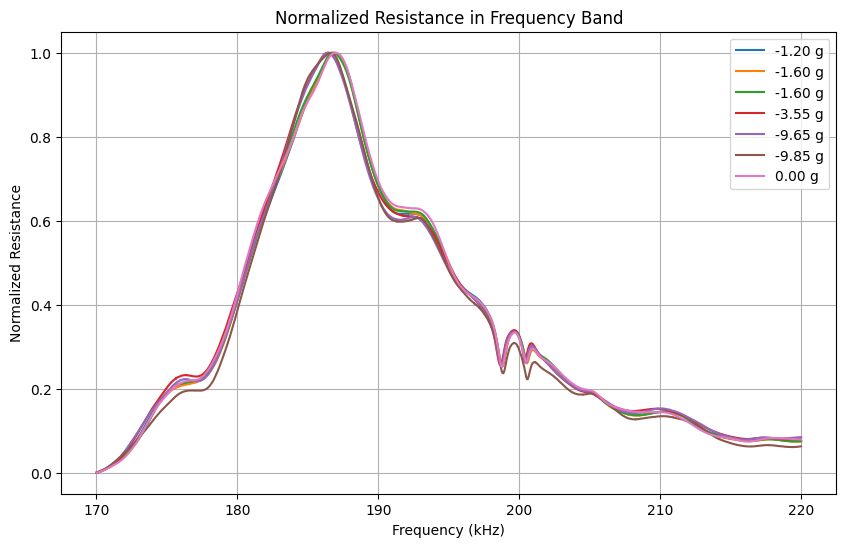

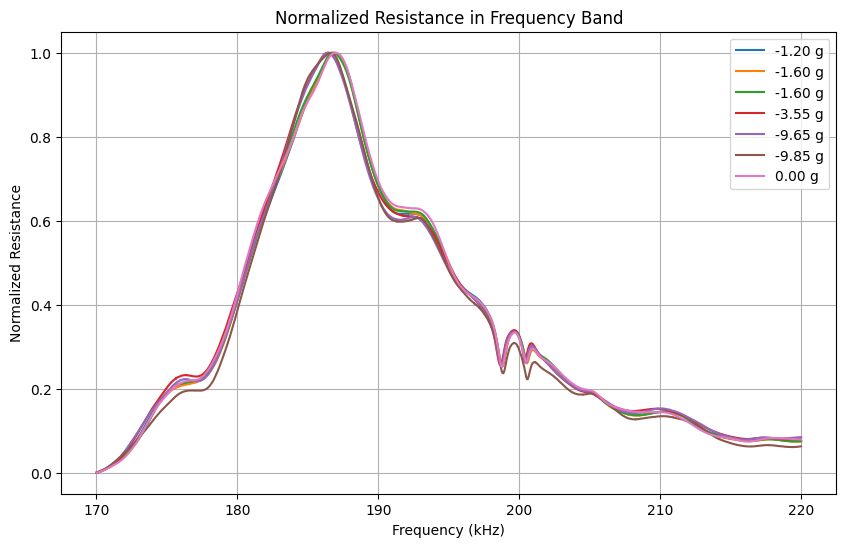

In [ ]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

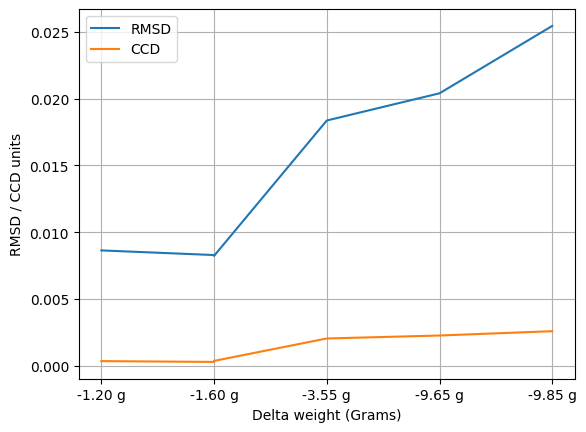

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot all except the last value which is the original, healthy dataset
ax1.plot(labels[:-1], rmsd_values[:-1], label='RMSD')
ax1.plot(labels[:-1],CCD_values[:-1], label='CCD')
ax1.set_ylabel('RMSD / CCD units')
ax1.legend(loc='upper left')
ax1.set_xlabel('Delta weight (Grams)')
plt.grid()
plt.show()


# Estimate Q factor

In [ ]:
import numpy as np

# Assume f_band and Z_meas_band.real are numpy arrays

sample4 = combined_data[combined_data["sample_file"] == "sample_4.csv"]
f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values



def estimate_q_factor(f_band, Z_real):
    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)
    
    # Find lower frequency at half power
    lower_idx = np.where(Z_real[:peak_idx] <= half_power)[0]
    if len(lower_idx) == 0:
        f1 = f_band[0]
    else:
        f1 = f_band[lower_idx[-1]]
    
    # Find higher frequency at half power
    upper_idx = np.where(Z_real[peak_idx:] <= half_power)[0]
    if len(upper_idx) == 0:
        f2 = f_band[-1]
    else:
        f2 = f_band[peak_idx + upper_idx[0]]
    
    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf
    
    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")
    return Q

estimate_q_factor(df["Frequency (Hz)"]/1000, df["Resistance (ohms)"])



Resonant frequency f0 = 0.27 kHz
Bandwidth Δf = 0.02 kHz
Estimated Q factor = 15.36


np.float64(15.358863678940194)

Resonant frequency f0 = 271.58 kHz
Bandwidth Δf = 85.61 kHz
Estimated Q factor = 3.17


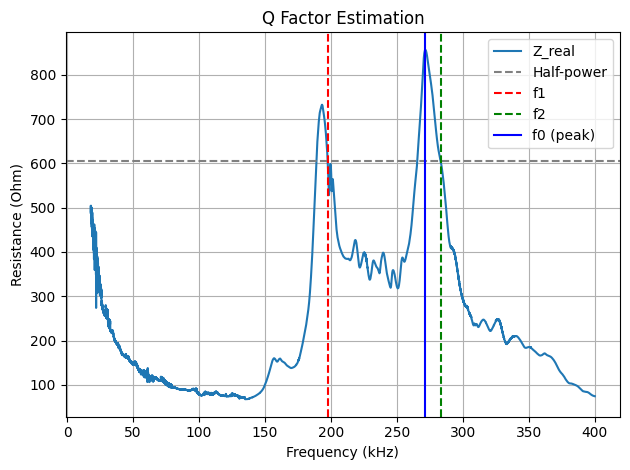

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#df = pd.read_csv("sample_1.csv", encoding="utf-8-sig")
#df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

f_band = df.iloc[:, 0].values  # First column: frequencies
Z_real = df.iloc[:, 1].values  # Second column: real part of Resistance


def estimate_q_factor(f_band, Z_real, plot=False):
    f_band = np.array(f_band)
    Z_real = np.array(Z_real)

    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)

    # Interpolation function
    interp = interp1d(f_band, Z_real, kind='cubic', bounds_error=False, fill_value="extrapolate")

    # Find lower half-power point
    lower_freqs = f_band[:peak_idx]
    lower_vals = Z_real[:peak_idx]
    f1 = f_band[0]
    for i in reversed(range(1, len(lower_vals))):
        if lower_vals[i] < half_power and lower_vals[i-1] > half_power:
            f1 = interp1d(lower_vals[i-1:i+1], lower_freqs[i-1:i+1])(half_power)
            break

    # Find upper half-power point
    upper_freqs = f_band[peak_idx:]
    upper_vals = Z_real[peak_idx:]
    f2 = f_band[-1]
    for i in range(1, len(upper_vals)):
        if upper_vals[i] < half_power and upper_vals[i-1] > half_power:
            f2 = interp1d(upper_vals[i-1:i+1], upper_freqs[i-1:i+1])(half_power)
            break

    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf

    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")

    if plot:
        plt.figure()
        plt.plot(f_band / 1e3, Z_real, label='Z_real')
        plt.axhline(half_power, color='gray', linestyle='--', label='Half-power')
        plt.axvline(f1 / 1e3, color='red', linestyle='--', label='f1')
        plt.axvline(f2 / 1e3, color='green', linestyle='--', label='f2')
        plt.axvline(f0 / 1e3, color='blue', linestyle='-', label='f0 (peak)')
        plt.xlabel("Frequency (kHz)")
        plt.ylabel("Resistance (Ohm)")
        plt.title("Q Factor Estimation")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return Q

Q = estimate_q_factor(f_band, Z_real, plot=True)


In [ ]:
print(combined_data["Frequency (Hz)"])

0          18000.0000
1          18010.0125
2          18020.0250
3          18030.0375
4          18040.0500
             ...     
801250    399976.5875
801251    399986.6000
801252    399996.6125
801253    400006.6250
801254    400016.6375
Name: Frequency (Hz), Length: 801255, dtype: float64


# Parameter estimation

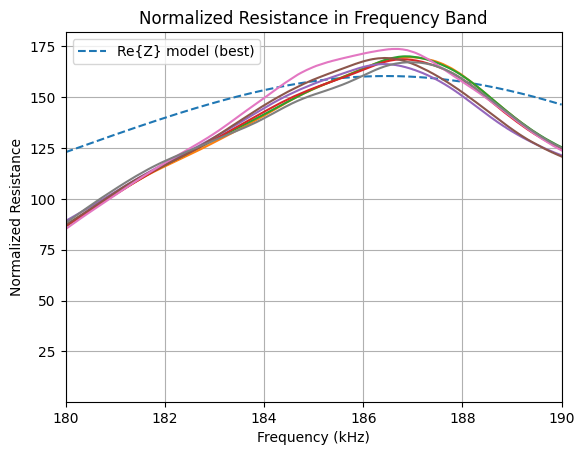

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

def mechanical_params_from_electrical(f, R1, L1, C1, C0):
    b1 = R1
    m1 = L1
    k1 = 1 / C1 if C1 != 0 else float('inf')  # Avoid division by zero
    k0 = 1 / C0 if C0 != 0 else float('inf')
    
    return {'b1': b1, 'm1': m1, 'k1': k1, 'k0': k0}

sample4 = combined_data[combined_data["sample_file"] == "sample_4.csv"]
f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

f_band = np.array(np.linspace(150000, 230000, 50000))

# --- Initial guesses (from you) ---
R1 = 130.0        # Ohms
L1 = 900e-6       # H
C1 = 0.93e-9      # F
C0 = 5.9e-9       # F

# --- Naive nested loops ---
Z_fit = model_Z(f_band, R1, L1, C1, C0)
# --- Plot ---
plt.figure()
plt.plot(f_band/1000, Z_fit.real, '--', label="Re{Z} model (best)")


f_min = min(f_band)
f_max = max(f_band)
freqs = dfs_for_sample[0]["Frequency (Hz)"].values
mask = (freqs >= f_min) & (freqs <= f_max)
freqs_kHz = freqs[mask] / 1000
for i, df in enumerate(dfs_for_sample):
    Z = (df["Resistance (ohms)"].values[mask])
    plt.plot(freqs_kHz, Z)


plt.xlabel("Frequency (kHz)")
plt.ylabel("Normalized Resistance")
plt.title("Normalized Resistance in Frequency Band")
plt.grid(True)
plt.legend()
plt.xlim(180, 190)
plt.show()

# New plotting

Best MSE: 2340.269878048676
Best C1: 8.990816326530612e-10 F


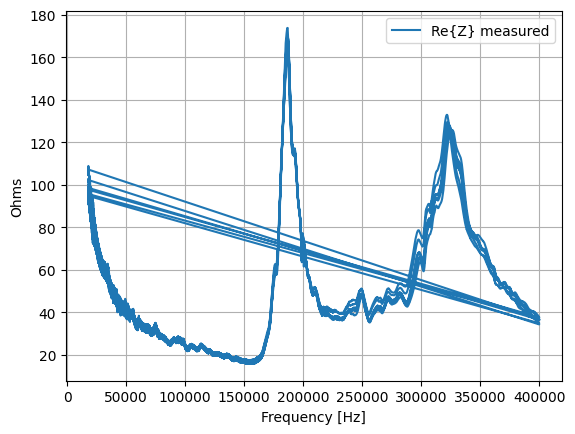

In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error

# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}

# --- Model function ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y_total = 1j*w*C0 + 1/Zs
    return 1 / Y_total

f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

# --- Optimizer function ---
def optimize_single_param(f_band, Z_meas_band, param_name, num_points=50, scale=0.5):
    if param_name not in param_guesses:
        raise ValueError(f"Invalid parameter: {param_name}")

    # Get initial values
    base_params = param_guesses.copy()
    base_value = base_params[param_name]
    
    # Create grid for the selected parameter
    param_grid = np.linspace(base_value * (1 - scale), base_value * (1 + scale), num_points)

    best_mse = np.inf
    best_value = base_value

    for val in param_grid:
        params = base_params.copy()
        params[param_name] = val
        Z_fit = model_Z(f_band, **params)
        mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
        if mse < best_mse:
            best_mse = mse
            best_value = val

    return best_mse, best_value


# Example usage:
best_mse, best_C1 = optimize_single_param(f_band, Z_meas_band, 'C1')
print(f"Best MSE: {best_mse}")
print(f"Best C1: {best_C1} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


# BVD

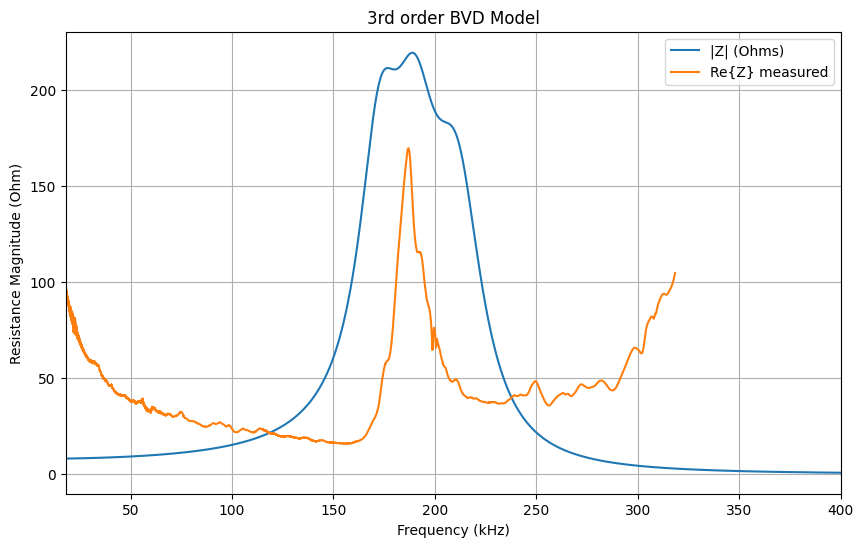

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


f = np.linspace(18e3, 400e3, 50000)
Z1 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"], param_guesses["L1"], param_guesses["C0"])
Z2 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"]*1.1, param_guesses["L1"]*1.1, param_guesses["C0"]*1.1)
Z3 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"]*0.9, param_guesses["L1"]*0.9, param_guesses["C0"]*0.9)

Z = Z1 + Z2 + Z3

plt.figure(figsize=(10,6))
plt.plot(f/1e3, np.real(Z), label='|Z| (Ohms)')
plt.plot(f_band[1:30000]/1e3, Z_meas_band[1:30000], label="Re{Z} measured")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance Magnitude (Ohm)')
plt.title(f'3rd order BVD Model')
plt.grid(True)
plt.legend()
plt.xlim(18, 400)
plt.show()


## Try to fit BVD model

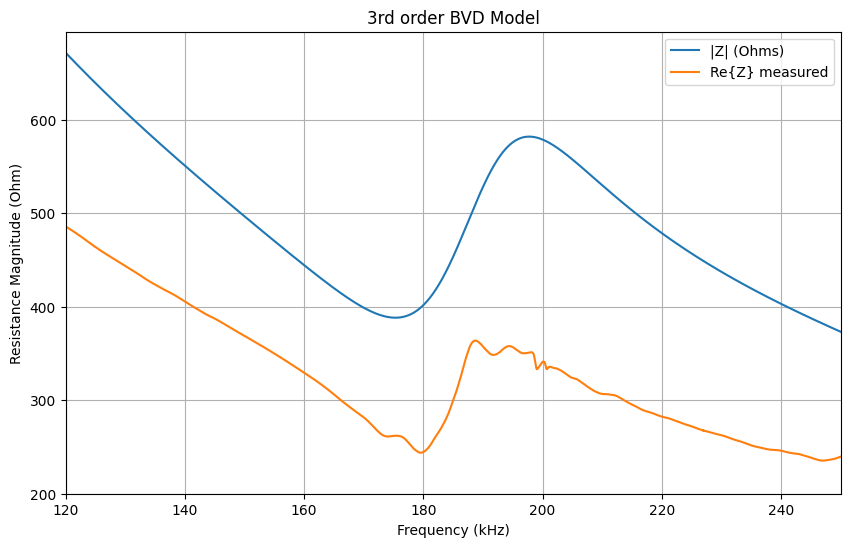

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f_band = sample4["Frequency (Hz)"].values
Z_meas_real = sample4["Resistance (ohms)"].values
Z_meas_imag = sample4["Reactance (ohms)"].values

Z_meas_band = Z_meas_real +1j * Z_meas_imag

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


f = np.linspace(120e3, 250e3, 50000)
Z1 = butterworth_van_dyke(f, param_guesses["R1"]*1, param_guesses["C1"]*1, param_guesses["L1"]*1, param_guesses["C0"]*1)
Z2 = butterworth_van_dyke(f, param_guesses["R1"]*0.6, param_guesses["C1"]*0.6, param_guesses["L1"]*0.6, param_guesses["C0"]*0.6)
Z3 = butterworth_van_dyke(f, param_guesses["R1"]*1, param_guesses["C1"]*1, param_guesses["L1"]*1, param_guesses["C0"]*1)

Z = Z1 + Z2 + Z3

plt.figure(figsize=(10,6))
plt.plot(f/1e3, np.abs(Z), label='|Z| (Ohms)')
plt.plot(f_band[10000:24000]/1e3, np.abs(Z_meas_band[10000:24000]), label="Re{Z} measured")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance Magnitude (Ohm)')
plt.title(f'3rd order BVD Model')
plt.grid(True)
plt.legend()
plt.xlim(120, 250)
plt.show()


Fitted parameters:
[1.55e+02 9.00e-04 8.90e-10 5.90e-09 9.30e+01 5.40e-04 5.34e-10 3.54e-09
 1.55e+01 9.00e-05 8.90e-11 5.90e-10]


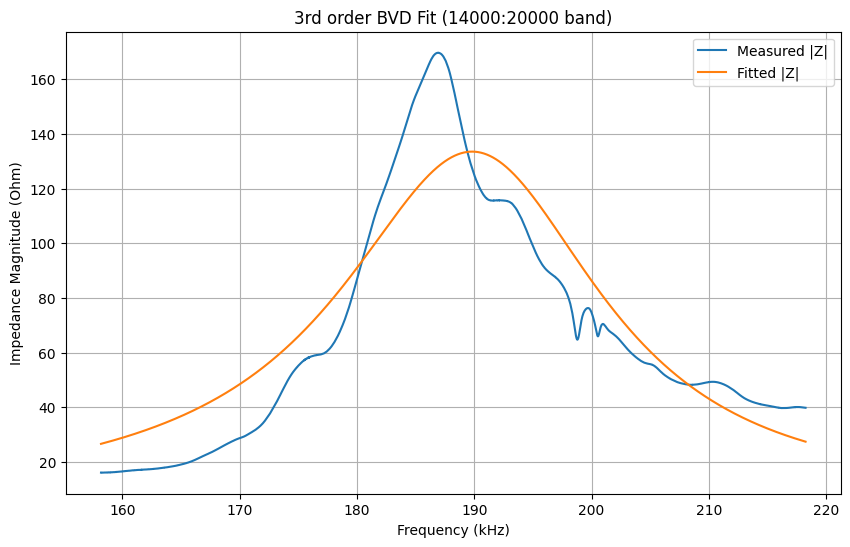

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Your measured data
f_band = sample4["Frequency (Hz)"].values
Z_meas_real = sample4["Resistance (ohms)"].values
Z_meas_imag = sample4["Reactance (ohms)"].values
Z_meas_band = Z_meas_real + 1j * Z_meas_imag

# Restrict to the band of interest
idx_low, idx_high = 14000, 20000
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]


def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


def bvd_sum(f, params):
    """3rd order sum of BVD resonators"""
    R1, L1, C1, C0 = params[0:4]
    R2, L2, C2, C02 = params[4:8]
    R3, L3, C3, C03 = params[8:12]
    Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
    Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
    Z3 = butterworth_van_dyke(f, R3, C3, L3, C03)
    return Z1 + Z2

# def bvd_sum(f, params):
#     """3rd order sum of BVD resonators"""
#     R1, L1, C1, C0 = params[0:4]
#     R2, L2, C2, C02 = params[4:8]
#     Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
#     Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
#     return Z1 + Z2


# --- Initial guesses (flattened for optimizer) ---
param_guesses = [
    155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
    155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6,  # resonator 2
    155.0*0.1, 900e-6*0.1, 0.89e-9*0.1, 5.9e-9*0.1   # resonator 3
]

# Define cost function (magnitude fit for now)
def residuals(params, f, Z_meas):
    Z_model = bvd_sum(f, params)
    return np.abs(Z_model) - np.abs(Z_meas)


# Run least squares
result = least_squares(residuals, param_guesses, args=(f_fit, Z_meas_fit))

fitted_params = result.x
print("Fitted parameters:")
print(fitted_params)

# Compute fitted curve
Z_fit = bvd_sum(f_fit, fitted_params)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.real(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.real(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, differential_evolution

# --- Band of interest ---
idx_low, idx_high = 14000, 20000
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total

def bvd_sum(f, params):
    """3rd order sum of BVD resonators"""
    R1, L1, C1, C0 = params[0:4]
    R2, L2, C2, C02 = params[4:8]
    R3, L3, C3, C03 = params[8:12]
    Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
    Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
    Z3 = butterworth_van_dyke(f, R3, C3, L3, C03)
    return Z1 + Z2 + Z3

# Cost function (fit both real & imag parts)
def residuals(params, f, Z_meas):
    Z_model = bvd_sum(f, params)
    return np.concatenate([
        np.real(Z_model) - np.real(Z_meas),
        np.imag(Z_model) - np.imag(Z_meas)
    ])

# Define search bounds (positive values, reasonable orders of magnitude)
bounds = [
    (1, 1e4),        # R1
    (1e-6, 1e-3),    # L1
    (1e-12, 1e-8),   # C1
    (1e-12, 1e-8),   # C0
    (1, 1e4),        # R2
    (1e-6, 1e-3),    # L2
    (1e-12, 1e-8),   # C2
    (1e-12, 1e-8),   # C02
    (1, 1e4),        # R3
    (1e-6, 1e-3),    # L3
    (1e-12, 1e-8),   # C3
    (1e-12, 1e-8)    # C03
]

def objective(p):
    return np.sum(residuals(p, f_fit, Z_meas_fit)**2)

param_guesses = np.array([
    155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
    155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6,
    155.0*0.1, 900e-6*0.1, 0.89e-9*0.1, 5.9e-9*0.1
])

result_de = differential_evolution(
    objective,
    bounds,
    maxiter=200,
    init=[param_guesses, 'latinhypercube'],  # include your guess + randoms
    workers=1
)


print("Differential evolution result:", result_de.fun)

# --- Step 2: Local refinement ---
result_ls = least_squares(residuals, result_de.x, args=(f_fit, Z_meas_fit))
fitted_params = result_ls.x

print("Fitted parameters:")
print(fitted_params)

# Compute fitted curve
Z_fit = bvd_sum(f_fit, fitted_params)

# Plot
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.abs(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.abs(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# --- Band of interest ---
idx_low, idx_high = 14000, 20000
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total

def bvd_sum(f, params):
    """3rd order sum of BVD resonators"""
    R1, L1, C1, C0 = params[0:4]
    R2, L2, C2, C02 = params[4:8]
    #R3, L3, C3, C03 = params[8:12]
    Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
    Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
    #Z3 = butterworth_van_dyke(f, R3, C3, L3, C03)
    return Z1 + Z2

# Cost function (real + imag parts)
def residuals(params, f, Z_meas):
    Z_model = bvd_sum(f, params)
    return np.concatenate([
        np.real(Z_model) - np.real(Z_meas),
        np.imag(Z_model) - np.imag(Z_meas)
    ])

# --- Initial guess (baseline) ---
# param_guesses = np.array([
#     155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
#     155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6,
#     155.0*0.1, 900e-6*0.1, 0.89e-9*0.1, 5.9e-9*0.1
# ])

# --- Initial guess (baseline) ---
param_guesses = np.array([
    155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
    155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6
    ])



# --- Multi-restart least squares ---
best = None
n_trials = 10000  # number of random restarts

for i in range(n_trials):
    # random scaling between 0.5x and 2x for each parameter
    guess = param_guesses * (0.5 + 1.5*np.random.rand(len(param_guesses)))
    res = least_squares(residuals, guess, args=(f_fit, Z_meas_fit))
    if best is None or res.cost < best.cost:
        best = res
        print(f"Trial {i+1}: New best cost = {res.cost:.4e}")

fitted_params = best.x
print("\nBest fitted parameters:")
print(fitted_params)

# Compute fitted curve
Z_fit = bvd_sum(f_fit, fitted_params)

# Plot
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.abs(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.abs(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'f_band' is not defined

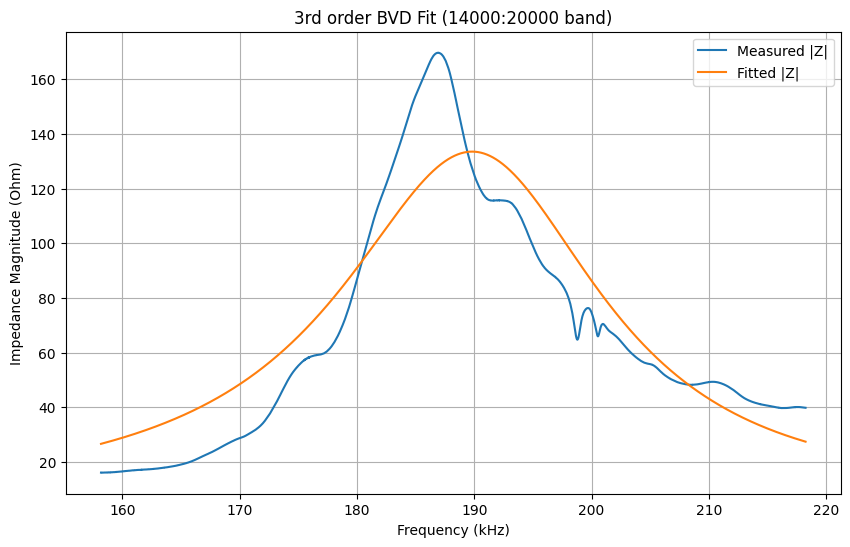

In [ ]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.real(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.real(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()

179551.5625


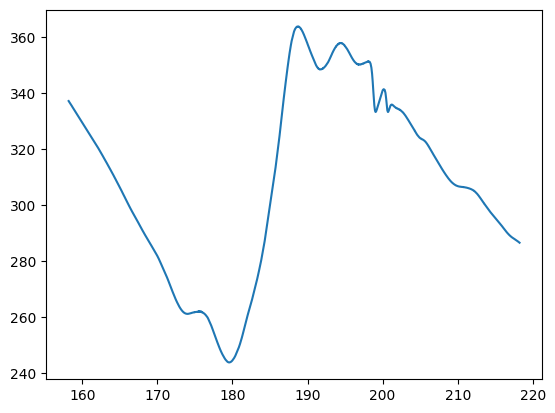

In [ ]:
plt.plot(f_fit/1e3,np.abs(Z_meas_fit))

AntiResonance = f_fit[np.argmin(np.abs(Z_meas_fit))]
Resonance = f_fit[np.argmax(np.abs(Z_meas_fit))]

Q

print(AntiResonance)

In [ ]:
import numpy as np

def bvd_from_specs(f0, Zpeak, Q):
    """
    f0: resonance frequency [Hz]
    Zpeak: peak impedance [Ohms]
    Q: quality factor
    """
    omega0 = 2 * np.pi * f0
    R = Zpeak
    L = R * Q / omega0
    C = 1 / (omega0**2 * L)
    return R, L, C

# Example
f0 = 186000        # 1 kHz
Zpeak = 169       # Ohms
Q = 22.9           # dimensionless

R, L, C = bvd_from_specs(f0, Zpeak, Q)
print("R =", R, "Ohm")
print("L =", L, "H")
print("C =", C, "F")


R = 169 Ohm
L = 0.0033115351895695922 H
C = 2.2109809489501582e-10 F


In [ ]:
import numpy as np
from scipy.signal import find_peaks

def two_dof_peak_analysis(freq, Zmag):
    """
    freq: frequency array
    Zmag: measured magnitude (e.g., |Z|) array
    Returns: list of dictionaries with resonance and antiresonance info:
             [{'f_res':..., 'Z_res':..., 'Q':..., 'f_anti':..., 'Z_anti':...}, ...]
    """
    # Find resonance peaks (impedance maxima)
    peaks, _ = find_peaks(Zmag, height=np.max(Zmag)*1)  # threshold at 10% of max

    # Find antiresonance (impedance minima)
    invZ = -Zmag
    anti_peaks, _ = find_peaks(invZ)
    
    peak_info = []

    for p in peaks:
        Zpeak = Zmag[p]
        fpeak = freq[p]

        # Estimate Q from -3dB points
        half_power = Zpeak / np.sqrt(2)
        # Find left side
        left_idx = p
        while left_idx > 0 and Zmag[left_idx] > half_power:
            left_idx -= 1
        f_left = freq[left_idx]

        # Find right side
        right_idx = p
        while right_idx < len(Zmag)-1 and Zmag[right_idx] > half_power:
            right_idx += 1
        f_right = freq[right_idx]

        BW = f_right - f_left
        Q = fpeak / BW if BW > 0 else np.nan

        # Find nearest antiresonance (impedance minimum) after this resonance
        f_anti, Z_anti = None, None
        candidates = [a for a in anti_peaks if freq[a] > fpeak]
        if candidates:
            a = candidates[0]  # take the first minimum after this peak
            f_anti = freq[a]
            Z_anti = Zmag[a]

        peak_info.append({
            'f_res': fpeak,
            'Z_res': Zpeak,
            'Q': Q,
            'f_anti': f_anti,
            'Z_anti': None
        })

    # Sort by resonance frequency
    peak_info = sorted(peak_info, key=lambda x: x['f_res'])
    return peak_info

# Example usage
freq = np.linspace(900, 1100, 1000)
Zmag = (
    np.abs(np.sin(2*np.pi*(freq-1000)/50)) +
    np.abs(np.sin(2*np.pi*(freq-1020)/30))
)  # overlapping peaks

peaks = two_dof_peak_analysis(freq, Zmag)
for pk in peaks:
    print(pk)


{'f_res': np.float64(1012.5125125125126), 'Z_res': np.float64(1.9999953300204034), 'Q': np.float64(109.94565217391275), 'f_anti': np.float64(1020.1201201201202), 'Z_anti': None}


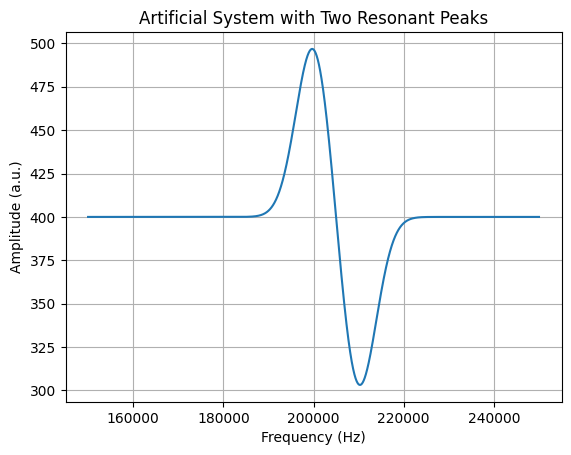

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Frequency axis
f = np.linspace(150000, 250000, 50000)

# Two artificial "resonances" (Gaussian bumps, not physical transfer functions)
peak1 = np.exp(-0.0000003 * ((f - 200000)/3)**2)   # centered at 30 Hz
peak2 = np.exp(-0.0000003 * ((f - 210000)/3)**2)   # centered at 70 Hz

# System response = sum of two peaks
H = ((peak1 - peak2) + 1) * 100 + 300

plt.plot(f, H)
plt.title("Artificial System with Two Resonant Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.show()

In [ ]:


def bvd_from_peakinfo(peak_info_list):
    bvd_params = []
    for peak_info in peak_info_list:
        f_res = peak_info['f_res']
        f_anti = peak_info['f_anti']
        Z_res = peak_info['Z_res']
        Q = peak_info['Q']

        if f_res is None or f_anti is None:
            continue  # skip incomplete peaks

        omega_res = 2 * np.pi * f_res

        # Motional branch
        Rm = Z_res
        Lm = Rm * Q / omega_res
        Cm = 1 / (omega_res**2 * Lm)

        # Static capacitance from anti-resonance
        C0 = Cm / ((f_anti/f_res)**2 - 1)

        bvd_params.append({'Rm': Rm, 'Lm': Lm, 'Cm': Cm, 'C0': C0})

    return bvd_params  

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total

import numpy as np

def bvd_from_complex(freq, Z, f_res, f_anti):
    """
    Compute BVD model parameters from complex impedance data.
    
    freq: frequency array [Hz]
    Z: complex impedance array [Ohm]
    f_res: resonance frequency [Hz] (series resonance)
    f_anti: anti-resonance frequency [Hz]
    
    Returns: dict with Rm, Lm, Cm, C0
    """
    omega_res = 2 * np.pi * f_res
    
    # Interpolate Z at resonance
    Z_res = np.interp(f_res, freq, Z.real) + 1j*np.interp(f_res, freq, Z.imag)
    
    # Motional resistance from real(Z) at resonance
    Rm = np.real(Z_res)
    
    # Estimate Q from bandwidth on reactance zero-crossing
    # Find -3dB points on |Z| near f_res
    Zmag = np.abs(Z)
    idx_res = np.argmin(np.abs(freq - f_res))
    Zpeak = Zmag[idx_res]
    half_power = Zpeak / np.sqrt(2)

    # left half power
    left_idx = idx_res
    while left_idx > 0 and Zmag[left_idx] < half_power:
        left_idx -= 1
    f_left = freq[left_idx]

    # right half power
    right_idx = idx_res
    while right_idx < len(Zmag)-1 and Zmag[right_idx] < half_power:
        right_idx += 1
    f_right = freq[right_idx]

    BW = f_right - f_left
    Q = f_res / BW if BW > 0 else np.nan

    # Motional branch Lm, Cm
    Lm = Rm * Q / omega_res
    Cm = 1 / (omega_res**2 * Lm)

    # Static capacitance C0 from antiresonance
    C0 = Cm / ((f_anti/f_res)**2 - 1)

    return {'Rm': Rm, 'Lm': Lm, 'Cm': Cm, 'C0': C0, 'Q': Q}



In [ ]:

# Example usage
#peakdata = two_dof_peak_analysis(f, H)
peakdata = two_dof_peak_analysis(f_fit,Z_meas_fit)


print(peakdata[0])
params = bvd_from_peakinfo(peakdata[0])

R1 = params['Rm']
C1 = params['Cm']
L1 = params['Lm']
C0 = params['C0']

print("Rm =", params['Rm'])
print("Lm =", params['Lm'])
print("Cm =", params['Cm'])
print("C0 =", params['C0'])
print("Q  =", params['Q'])


Z = butterworth_van_dyke(f_fit, R1, C1, L1, C0)

# plt.plot(f, H)
plt.plot(f_fit,np.abs(Z_meas_fit))

#plt.plot(f_fit,np.abs(Z))

# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


{'f_res': np.float64(186920.7625), 'Z_res': np.complex128(169.66578999332685-294.7750303120992j), 'Q': np.float64(22.96278022705319), 'f_anti': np.float64(186940.7875), 'Z_anti': None}


C:\Users\adres\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


TypeError: string indices must be integers, not 'str'

{'Rm': np.float64(363.7218116854465), 'Lm': np.float64(0.0015835632418983085), 'Cm': np.float64(4.492078109827851e-10), 'C0': np.float64(4.232939183699474e-06)}


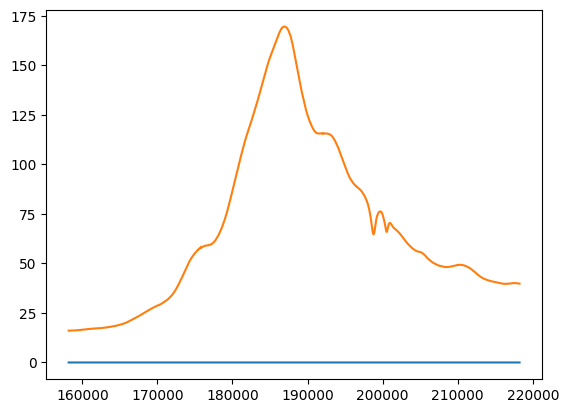

In [ ]:
import numpy as np

def bvd_from_peakinfo(peak_info_list):
    """
    Convert peak analysis output into BVD model parameters.
    
    peak_info_list: list of dicts (output of two_dof_peak_analysis)
    
    Returns: list of dicts with Rm, Lm, Cm, C0 for each resonance
    """
    bvd_params = []
    for peak_info in peak_info_list:
        f_res = np.real(peak_info['f_res'])
        f_anti = np.real(peak_info['f_anti'])
        Z_res = np.real(peak_info['Z_res'])
        Q = np.real(peak_info['Q'])

        if f_res is None or f_anti is None:
            continue  # skip incomplete peaks

        omega_res = 2 * np.pi * f_res

        # Motional branch
        Rm = Z_res
        Lm = Rm * Q / omega_res
        Cm = 1 / (omega_res**2 * Lm)

        # Static capacitance from anti-resonance
        C0 = Cm / ((f_anti/f_res)**2 - 1)

        bvd_params.append({'Rm': Rm, 'Lm': Lm, 'Cm': Cm, 'C0': C0})

    return bvd_params


peakdata = two_dof_peak_analysis(f_fit, np.abs(Z_meas_fit))



# peakdata = [
#     {'f_res': 186000, 'Z_res': 169, 'Q': 22.9, 'f_anti': 188000, 'Z_anti': None}]

# peakdata =[
#     # Example usage
# {'f_res': 186920.7625, 'Z_res': 169.66578999332685, 'Q': 22.96278022705319, 'f_anti': 186940.7875, 'Z_anti': None}
# ]

params = bvd_from_peakinfo(peakdata)
for p in params:
    print(p)

R1 = params[0]['Rm']
C1 = params[0]['Cm']
L1 = params[0]['Lm']
C0 = params[0]['C0']

Z = butterworth_van_dyke(f_fit, R1, C1, L1, C0)

# plt.plot(f, H)
plt.plot(f_fit,np.real(Z))
plt.plot(f_fit,np.real(Z_meas_fit))



Fit cost: 65.91876796226032
Fitted params:
R1 = 600.0000000000794
C1 = 2.2904146888883818e-10
L1 = 0.0033115352230320295
C0 = 3.0688551709289378e-09


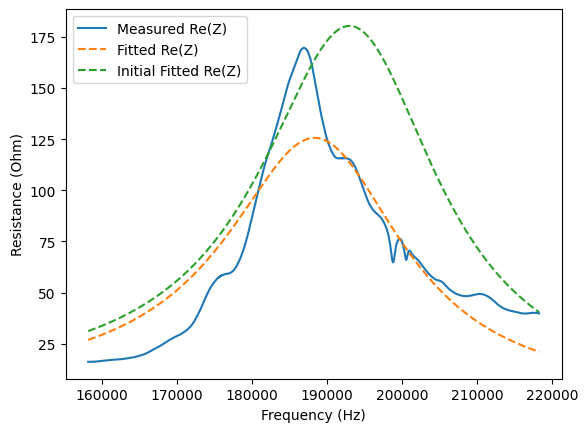

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Measured data (must be defined outside this snippet)
# f_fit: frequency array in Hz
# Z_meas_fit: measured complex impedance
f_fit = f_fit  # <-- replace with your frequency array
Z_meas = Z_meas_fit

# BVD impedance model
def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


def residuals(params, f, Z_meas):
    R1, C1, L1, C0 = params
    Z_model = butterworth_van_dyke(f, R1, C1, L1, C0)
    res_real = (Z_model.real - Z_meas.real) / np.max(np.abs(Z_meas.real))
    res_imag = (Z_model.imag - Z_meas.imag) / np.max(np.abs(Z_meas.imag))
    return np.concatenate([res_real, res_imag])


# Initial guess: [R1, C1, L1, C0]
R1 = 600
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0 = 2.5e-9

initial_guess = [R1,C1, L1, C0]

# Perform fit
lower = [200, 1e-11, 1e-7, 1e-15]   # R, C1, L, C0
upper = [1e4, 1e-9, 1e-2, 1e-6]

result = least_squares(
    residuals, 
    initial_guess, 
    args=(f_fit, Z_meas),
    bounds=(lower, upper),
    method="trf",
    ftol=1e-15, xtol=1e-15, gtol=1e-15,
    max_nfev=10000
)


R1_fit, C1_fit, L1_fit, C0_fit = result.x

print("Fit cost:", result.cost)
print("Fitted params:")
print("R1 =", R1_fit)
print("C1 =", C1_fit)
print("L1 =", L1_fit)
print("C0 =", C0_fit)


# Evaluate fitted impedance
fitted_Z = butterworth_van_dyke(f_fit, R1_fit, C1_fit, L1_fit, C0_fit)

Initial_fitted_Z = butterworth_van_dyke(f_fit, R1, C1, L1, C0)


# Plot measured vs fitted real part
plt.figure()
plt.plot(f_fit, np.real(Z_meas), label="Measured Re(Z)")
plt.plot(f_fit, np.real(fitted_Z), '--', label="Fitted Re(Z)")
plt.plot(f_fit, np.real(Initial_fitted_Z), '--', label="Initial Fitted Re(Z)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Resistance (Ohm)")
plt.show()


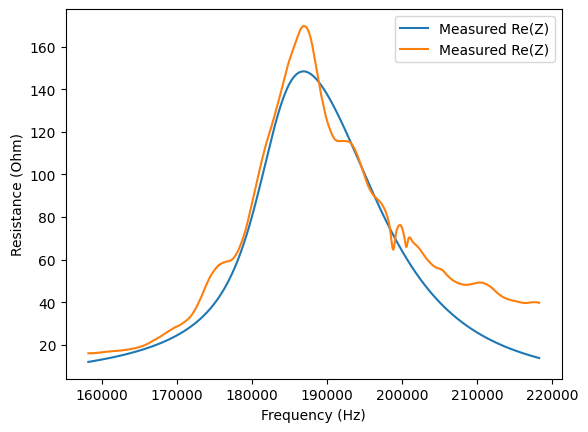

In [ ]:
# BVD impedance model
def TwoDOF_butterworth_van_dyke(f, R1, C1, L1, C0_1, R2, C2, L2, C0_2):
    w = 2 * np.pi * f
    Z1 = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y1 = 1j*w*C0_1 + 1/Z1

    Z2 = R2 + 1j*w*L2 + 1/(1j*w*C2)
    Y2 = 1j*w*C0_2 + 1/Z2
    return 1 / (Y1+Y2)

# Initial guess: [R1, C1, L1, C0]
R1 = 600
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 200
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9


Ztest = TwoDOF_butterworth_van_dyke(f_fit, R1, C1, L1, C0_1, R2, C2, L2, C0_2)

# Plot measured vs fitted real part
plt.figure()
plt.plot(f_fit, np.real(Ztest), label="Measured Re(Z)")
plt.plot(f_fit, np.real(Z_meas), label="Measured Re(Z)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Resistance (Ohm)")
plt.show()

Fit cost: 1121632.09674579
Fitted params:
R1 = 550.000000000092
C1 = 5.380146057444517e-10
L1 = 0.003311541440801789
C0 = 1.7205033145671147e-09
R2 = 150.00000000067365
C2 = 5.752330041697755e-10
L2 = 0.003115406522091358
C0_2 = 2.1259467487290782e-09


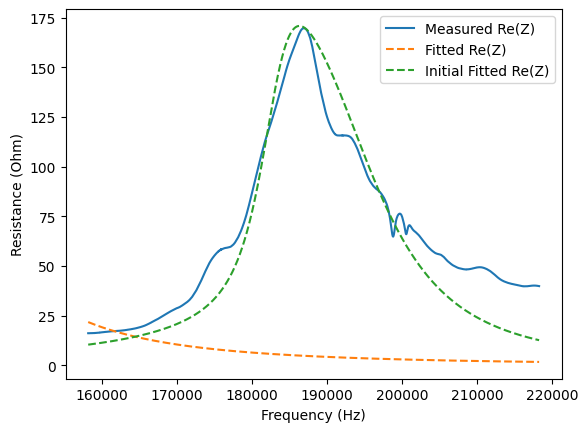

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Measured data (must be defined outside this snippet)
# f_fit: frequency array in Hz
# Z_meas_fit: measured complex impedance
f_fit = f_fit  # <-- replace with your frequency array
Z_meas = Z_meas_fit

# BVD impedance model
def TwoDOF_butterworth_van_dyke(f, R1, C1, L1, C0_1, R2, C2, L2, C0_2):
    w = 2 * np.pi * f
    Z1 = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y1 = 1j*w*C0_1 + 1/Z1

    Z2 = R2 + 1j*w*L2 + 1/(1j*w*C2)
    Y2 = 1j*w*C0_2 + 1/Z2
    return 1 / (Y1+Y2)


def residuals(params, f, Z_meas):
    R1, C1, L1, C0_1, R2, C2, L2, C0_2 = params
    Z_model = TwoDOF_butterworth_van_dyke(f, R1, C1, L1, C0_1, R2, C2, L2, C0_2)
    res_real = (Z_model.real - Z_meas.real) / np.max(np.abs(Z_meas.real))
    res_imag = (Z_model.imag - Z_meas.imag) / np.max(np.abs(Z_meas.imag))
    return np.concatenate([1*res_real, 100*res_imag])  # emphasize real part



# Initial guess: [R1, C1, L1, C0]
R1 = 550
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 150
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9

initial_guess = [R1,C1, L1, C0_1, R2, C2, L2, C0_2]

# Perform fit
lower = [200, 1e-11, 1e-7, 1e-15,
          1, 1e-15, 1e-10, 1e-15]   # R, C1, L, C0

upper = [1e3, 1e-9, 1e-2, 1e-6,
          1e3, 1e-9, 1e-1, 1e-3]

result = least_squares(
    residuals, 
    initial_guess, 
    args=(f_fit, Z_meas),
    bounds=(lower, upper),
    method="trf",
    ftol=1e-15, xtol=1e-15, gtol=1e-15,
    max_nfev=10000
)

R1_fit, C1_fit, L1_fit, C0_1_fit, R2_fit, C2_fit, L2_fit, C0_2_fit = result.x

print("Fit cost:", result.cost)
print("Fitted params:")
print("R1 =", R1_fit)
print("C1 =", C1_fit)
print("L1 =", L1_fit)
print("C0 =", C0_1_fit)
print("R2 =", R2_fit)
print("C2 =", C2_fit)
print("L2 =", L2_fit)
print("C0_2 =", C0_2_fit)


# Evaluate fitted impedance
fitted_Z = TwoDOF_butterworth_van_dyke(f_fit, R1_fit, C1_fit, L1_fit, C0_fit, R2_fit, C2_fit, L2_fit, C0_2_fit)
Initial_fitted_Z = TwoDOF_butterworth_van_dyke(f_fit, R1, C1, L1, C0, R2, C2, L2, C0_2)

# Plot measured vs fitted real part
plt.figure()
plt.plot(f_fit, np.real(Z_meas), label="Measured Re(Z)")
plt.plot(f_fit, np.real(fitted_Z), '--', label="Fitted Re(Z)")
plt.plot(f_fit, np.real(Initial_fitted_Z), '--', label="Initial Fitted Re(Z)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Resistance (Ohm)")
plt.show()


# Chat-GPT fit that seems to work!

## Get data

In [ ]:

# Example usage
folder_name = "2024-09-19-Dmg6"
sample_file = "sample_4.csv"
idx_low, idx_high = 14000, 20000


sample_data = get_sample_data(folder_name, sample_file)

f_band = sample_data["Frequency (Hz)"].values
Z_meas_real =  sample_data["Resistance (ohms)"].values
Z_meas_imag =  sample_data["Reactance (ohms)"].values

Z_meas_band = Z_meas_real + 1j*Z_meas_imag

# Restrict to the band of interest
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]




## Do the fitting

Derived initial guesses from your R,L,C:
fs1 = 186000.000 Hz, Q1 = 7.037, Cm1 = 2.211e-10, C01 = 2.500e-09
fs2 = 179947.107 Hz, Q2 = 23.482, Cm2 = 2.511e-10, C02 = 2.500e-09

Initial theta and bounds:
initial_theta = [np.float64(186000.0), np.float64(7.036545454545454), 2.2109809489501582e-10, 2.5e-09, np.float64(179947.10660722744), np.float64(23.482297556628414), 2.510980948950158e-10, 2.5e-09]
lower = [np.float64(158100.0), 0.1, 1e-14, 2.5e-10, np.float64(152955.04061614332), 0.1, 1e-14, 2.5e-10]
upper = [np.float64(213899.99999999997), 100000.0, 2.210980948950158e-07, 2.5e-07, np.float64(206939.17259831153), 100000.0, 2.510980948950158e-07, 2.5e-07]

Initial mean abs error (model vs measured): 1.462263e+02
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4325e+03                                    8.19e+04    
       1              2         1.4325e+03      0.00e+00       0.00e+00       8.19e+04    
`xtol` 

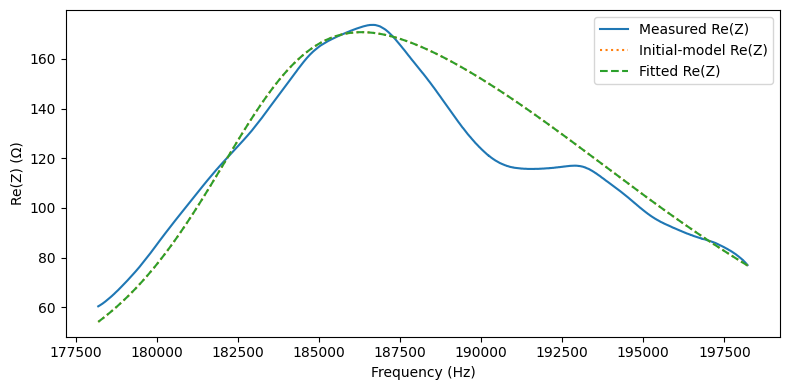

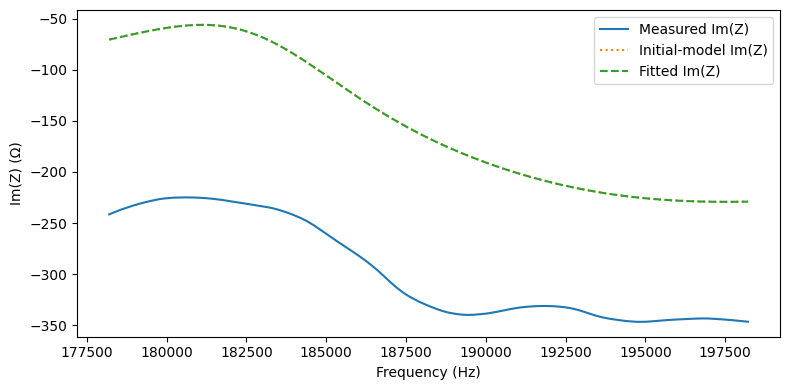


Derived fitted R/L/C:
R1 = 550, L1 = 0.00331154, C1 = 2.21098e-10, C01 = 2.5e-09
R2 = 150, L2 = 0.00311535, C2 = 2.51098e-10, C02 = 2.5e-09


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ------------------------
# YOUR measured data variables must already exist:
# f_fit (Hz), Z_meas_fit (complex)
f_fit = f_fit
Z_meas = Z_meas_fit
# ------------------------

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    """Given R, L, C (motional C), and C0, return fs (Hz), Q, Cm, C0"""
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- Two-DOF model using theta = [fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02] ---
def TwoDOF_bvd_theta(f, theta):
    fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02 = theta
    # convert to R,L,C
    R1, L1, C1, C01 = RLC_from_fsQCm(fs1, Q1, Cm1, C01)
    R2, L2, C2, C02 = RLC_from_fsQCm(fs2, Q2, Cm2, C02)

    w = 2*np.pi*f
    Z1 = R1 + 1j*w*L1 + 1.0/(1j*w*C1)
    Y1 = 1j*w*C01 + 1.0/Z1
    Z2 = R2 + 1j*w*L2 + 1.0/(1j*w*C2)
    Y2 = 1j*w*C02 + 1.0/Z2
    return 1.0 / (Y1 + Y2)

# --- weighted residuals ---
def residuals_theta(theta, f, Z_meas, peak_guesses=None, w_real=5.0, w_imag=1.0):
    Z_model = TwoDOF_bvd_theta(f, theta)

    # frequency weights (sum of Gaussians)
    W = np.ones_like(f, dtype=float)
    if peak_guesses is not None:
        for fc in peak_guesses:
            sigma = 0.03 * fc  # tightened to 3% band by default
            W += np.exp(-0.5*((f - fc)/sigma)**2)

    # scale each channel by robust scale (median abs)
    sR = np.median(np.abs(Z_meas.real)) + 1e-12
    sI = np.median(np.abs(Z_meas.imag)) + 1e-12

    rR = w_real * W * (Z_model.real - Z_meas.real) / sR
    rI = w_imag * W * (Z_model.imag - Z_meas.imag) / sI
    return np.concatenate([rR, rI])

# -------------------------
# Use your original R/L/C initial values to produce initial theta
# (these came from your message)
R1 = 550
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 150
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9

# compute fs, Q, Cm from those
fs1_guess, Q1_guess, Cm1_guess, C01_guess = bvd_from_RLC(R1, L1, C1, C0_1)
fs2_guess, Q2_guess, Cm2_guess, C02_guess = bvd_from_RLC(R2, L2, C2, C0_2)

print("Derived initial guesses from your R,L,C:")
print(f"fs1 = {fs1_guess:.3f} Hz, Q1 = {Q1_guess:.3f}, Cm1 = {Cm1_guess:.3e}, C01 = {C01_guess:.3e}")
print(f"fs2 = {fs2_guess:.3f} Hz, Q2 = {Q2_guess:.3f}, Cm2 = {Cm2_guess:.3e}, C02 = {C02_guess:.3e}")

initial_theta = [fs1_guess, Q1_guess, Cm1_guess, C01_guess,
                 fs2_guess, Q2_guess, Cm2_guess, C02_guess]

# sensible bounds around these derived values
fs_pad = 0.15  # ±15% on frequency
lower = [
    (1-fs_pad)*fs1_guess, 1e-1, 1e-14, max(1e-13, C01_guess*0.1),
    (1-fs_pad)*fs2_guess, 1e-1, 1e-14, max(1e-13, C02_guess*0.1)
]
upper = [
    (1+fs_pad)*fs1_guess, 1e5, Cm1_guess*1e3, C01_guess*1e2,
    (1+fs_pad)*fs2_guess, 1e5, Cm2_guess*1e3, C02_guess*1e2
]

print("\nInitial theta and bounds:")
print("initial_theta =", initial_theta)
print("lower =", lower)
print("upper =", upper)

# Quick check: show how close initial model is to data (cost-like simple metric)
Z_init = TwoDOF_bvd_theta(f_fit, initial_theta)
init_err = np.mean(np.abs(Z_init - Z_meas))
print(f"\nInitial mean abs error (model vs measured): {init_err:.6e}")

# Now run the fit
result = least_squares(
    residuals_theta,
    initial_theta,
    args=(f_fit, Z_meas, [fs1_guess, fs2_guess], 5.0, 1.0),
    bounds=(lower, upper),
    method="trf",
    loss="soft_l1",
    ftol=1e-12, xtol=1e-12, gtol=1e-12,
    max_nfev=20000,
    verbose=2
)

print("\nFit cost:", result.cost)
labels = ["fs1","Q1","Cm1","C01","fs2","Q2","Cm2","C02"]
for name, val in zip(labels, result.x):
    print(f"{name} = {val}")

# Evaluate fitted model
Z_fit = TwoDOF_bvd_theta(f_fit, result.x)

# Plot measured vs fitted (real & imag)
plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.real, label="Measured Re(Z)")
plt.plot(f_fit, Z_init.real, ':', label="Initial-model Re(Z)")
plt.plot(f_fit, Z_fit.real, '--', label="Fitted Re(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Re(Z) (Ω)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.imag, label="Measured Im(Z)")
plt.plot(f_fit, Z_init.imag, ':', label="Initial-model Im(Z)")
plt.plot(f_fit, Z_fit.imag, '--', label="Fitted Im(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Im(Z) (Ω)")
plt.tight_layout(); plt.show()

# Print derived R,L from fitted params for interpretability
fs1_f, Q1_f, Cm1_f, C01_f, fs2_f, Q2_f, Cm2_f, C02_f = result.x
R1_f, L1_f, C1_f, _ = RLC_from_fsQCm(fs1_f, Q1_f, Cm1_f, C01_f)
R2_f, L2_f, C2_f, _ = RLC_from_fsQCm(fs2_f, Q2_f, Cm2_f, C02_f)
print("\nDerived fitted R/L/C:")
print(f"R1 = {R1_f:.6g}, L1 = {L1_f:.6g}, C1 = {C1_f:.6g}, C01 = {C01_f:.6g}")
print(f"R2 = {R2_f:.6g}, L2 = {L2_f:.6g}, C2 = {C2_f:.6g}, C02 = {C02_f:.6g}")


Derived initial guesses from your R,L,C:
fs1 = 186000.000 Hz, Q1 = 7.037, Cm1 = 2.211e-10, C01 = 2.500e-09
fs2 = 179947.107 Hz, Q2 = 23.482, Cm2 = 2.511e-10, C02 = 2.500e-09

Initial theta and bounds:
initial_theta = [np.float64(186000.0), np.float64(7.036545454545454), 2.2109809489501582e-10, 2.5e-09, np.float64(179947.10660722744), np.float64(23.482297556628414), 2.510980948950158e-10, 2.5e-09]
lower = [np.float64(158100.0), 0.1, 1e-14, 2.5e-10, np.float64(152955.04061614332), 0.1, 1e-14, 2.5e-10]
upper = [np.float64(213899.99999999997), 100000.0, 2.210980948950158e-07, 2.5e-07, np.float64(206939.17259831153), 100000.0, 2.510980948950158e-07, 2.5e-07]

Initial mean abs error (model vs measured): 1.427122e+02
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7070e+03                                    9.09e+04    
       1              5         6.7070e+03      0.00e+00       0.00e+00       9.09e+04    
`xtol` 

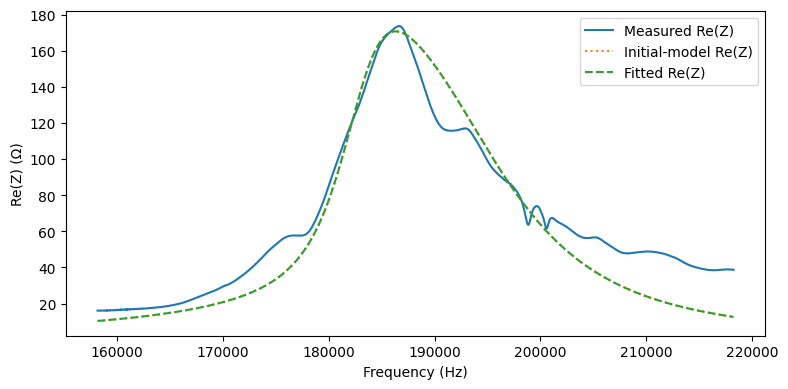

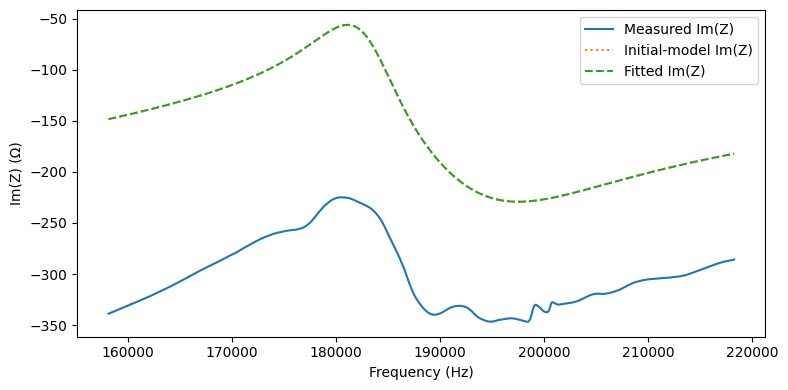


Derived fitted R/L/C:
R1 = 550, L1 = 0.00331154, C1 = 2.21098e-10, C01 = 2.5e-09
R2 = 150, L2 = 0.00311535, C2 = 2.51098e-10, C02 = 2.5e-09


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ------------------------
# YOUR measured data variables must already exist:
# f_fit (Hz), Z_meas_fit (complex)
f_fit = f_fit
Z_meas = Z_meas_fit
# ------------------------

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    """Given R, L, C (motional C), and C0, return fs (Hz), Q, Cm, C0"""
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- Two-DOF model using theta = [fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02] ---
def TwoDOF_bvd_theta(f, theta):
    fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02 = theta
    # convert to R,L,C
    R1, L1, C1, C01 = RLC_from_fsQCm(fs1, Q1, Cm1, C01)
    R2, L2, C2, C02 = RLC_from_fsQCm(fs2, Q2, Cm2, C02)

    w = 2*np.pi*f
    Z1 = R1 + 1j*w*L1 + 1.0/(1j*w*C1)
    Y1 = 1j*w*C01 + 1.0/Z1
    Z2 = R2 + 1j*w*L2 + 1.0/(1j*w*C2)
    Y2 = 1j*w*C02 + 1.0/Z2
    return 1.0 / (Y1 + Y2)

# --- weighted residuals ---
def residuals_theta(theta, f, Z_meas, peak_guesses=None, w_real=5.0, w_imag=1.0):
    Z_model = TwoDOF_bvd_theta(f, theta)

    # frequency weights (sum of Gaussians)
    W = np.ones_like(f, dtype=float)
    if peak_guesses is not None:
        for fc in peak_guesses:
            sigma = 0.03 * fc  # tightened to 3% band by default
            W += np.exp(-0.5*((f - fc)/sigma)**2)

    # scale each channel by robust scale (median abs)
    sR = np.median(np.abs(Z_meas.real)) + 1e-12
    sI = np.median(np.abs(Z_meas.imag)) + 1e-12

    rR = w_real * W * (Z_model.real - Z_meas.real) / sR
    rI = w_imag * W * (Z_model.imag - Z_meas.imag) / sI
    return np.concatenate([rR, rI])

# -------------------------
# Use your original R/L/C initial values to produce initial theta
# (these came from your message)
R1 = 550
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 150
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9

# compute fs, Q, Cm from those
fs1_guess, Q1_guess, Cm1_guess, C01_guess = bvd_from_RLC(R1, L1, C1, C0_1)
fs2_guess, Q2_guess, Cm2_guess, C02_guess = bvd_from_RLC(R2, L2, C2, C0_2)

print("Derived initial guesses from your R,L,C:")
print(f"fs1 = {fs1_guess:.3f} Hz, Q1 = {Q1_guess:.3f}, Cm1 = {Cm1_guess:.3e}, C01 = {C01_guess:.3e}")
print(f"fs2 = {fs2_guess:.3f} Hz, Q2 = {Q2_guess:.3f}, Cm2 = {Cm2_guess:.3e}, C02 = {C02_guess:.3e}")

initial_theta = [fs1_guess, Q1_guess, Cm1_guess, C01_guess,
                 fs2_guess, Q2_guess, Cm2_guess, C02_guess]

# sensible bounds around these derived values
fs_pad = 0.15  # ±15% on frequency
lower = [
    (1-fs_pad)*fs1_guess, 1e-1, 1e-14, max(1e-13, C01_guess*0.1),
    (1-fs_pad)*fs2_guess, 1e-1, 1e-14, max(1e-13, C02_guess*0.1)
]
upper = [
    (1+fs_pad)*fs1_guess, 1e5, Cm1_guess*1e3, C01_guess*1e2,
    (1+fs_pad)*fs2_guess, 1e5, Cm2_guess*1e3, C02_guess*1e2
]

print("\nInitial theta and bounds:")
print("initial_theta =", initial_theta)
print("lower =", lower)
print("upper =", upper)

# Quick check: show how close initial model is to data (cost-like simple metric)
Z_init = TwoDOF_bvd_theta(f_fit, initial_theta)
init_err = np.mean(np.abs(Z_init - Z_meas))
print(f"\nInitial mean abs error (model vs measured): {init_err:.6e}")

# Now run the fit
result = least_squares(
    residuals_theta,
    initial_theta,
    args=(f_fit, Z_meas, [fs1_guess, fs2_guess], 5.0, 1.0),
    bounds=(lower, upper),
    method="trf",
    loss="soft_l1",
    ftol=1e-12, xtol=1e-12, gtol=1e-12,
    max_nfev=20000,
    verbose=2
)

print("\nFit cost:", result.cost)
labels = ["fs1","Q1","Cm1","C01","fs2","Q2","Cm2","C02"]
for name, val in zip(labels, result.x):
    print(f"{name} = {val}")

# Evaluate fitted model
Z_fit = TwoDOF_bvd_theta(f_fit, result.x)

# Plot measured vs fitted (real & imag)
plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.real, label="Measured Re(Z)")
plt.plot(f_fit, Z_init.real, ':', label="Initial-model Re(Z)")
plt.plot(f_fit, Z_fit.real, '--', label="Fitted Re(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Re(Z) (Ω)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.imag, label="Measured Im(Z)")
plt.plot(f_fit, Z_init.imag, ':', label="Initial-model Im(Z)")
plt.plot(f_fit, Z_fit.imag, '--', label="Fitted Im(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Im(Z) (Ω)")
plt.tight_layout(); plt.show()

# Print derived R,L from fitted params for interpretability
fs1_f, Q1_f, Cm1_f, C01_f, fs2_f, Q2_f, Cm2_f, C02_f = result.x
R1_f, L1_f, C1_f, _ = RLC_from_fsQCm(fs1_f, Q1_f, Cm1_f, C01_f)
R2_f, L2_f, C2_f, _ = RLC_from_fsQCm(fs2_f, Q2_f, Cm2_f, C02_f)
print("\nDerived fitted R/L/C:")
print(f"R1 = {R1_f:.6g}, L1 = {L1_f:.6g}, C1 = {C1_f:.6g}, C01 = {C01_f:.6g}")
print(f"R2 = {R2_f:.6g}, L2 = {L2_f:.6g}, C2 = {C2_f:.6g}, C02 = {C02_f:.6g}")


In [4]:
# Example usage
folder_name = "2024-09-19-Dmg6"
sample_file = "sample_4.csv"
idx_low, idx_high = 14000, 20000


sample_data = get_sample_data(folder_name, sample_file)

f_band = sample_data["Frequency (Hz)"].values
Z_meas_real =  sample_data["Resistance (ohms)"].values
Z_meas_imag =  sample_data["Reactance (ohms)"].values

Z_meas_band = Z_meas_real + 1j*Z_meas_imag

# Restrict to the band of interest
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares

# --- measured data ---
# f_fit (Hz), Z_meas_fit (complex)
f_fit = f_fit
Z_meas = Z_meas_fit

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- generalized N-DOF BVD model ---
def NDOF_bvd_theta(f, theta):
    n = len(theta) // 4
    w = 2*np.pi*f
    Y_total = np.zeros_like(f, dtype=complex)

    for i in range(n):
        fs, Q, Cm, C0 = theta[i*4:(i+1)*4]
        R, L, C, C0 = RLC_from_fsQCm(fs, Q, Cm, C0)
        Z = R + 1j*w*L + 1/(1j*w*C)
        Y = 1j*w*C0 + 1/Z
        Y_total += Y

    return 1.0 / Y_total

# --- cost function for differential_evolution ---
def bvd_cost(theta, f, Z_meas):
    Z_model = NDOF_bvd_theta(f, theta)
    # weighted sum of squared errors (real + imag)
    err = np.abs(Z_model.real - Z_meas.real)**2 + np.abs(Z_model.imag - Z_meas.imag)**2
    return np.sum(err)

# -------------------------
# Example: arbitrary number of resonators
R_list = [550, 150, 300]      # add more as needed
L_list = [0.00331, 0.00312, 0.003]
C_list = [2.211e-10, 2.511e-10, 2.4e-10]
C0_list = [2.5e-9, 2.5e-9, 2.5e-9]

initial_theta = []
bounds = []
fs_pad = 0.15

In [8]:
# Example usage
Z_meas_samples = []

folder_names = ["HealthyDataset", "2024-08-22-Dmg1", "2024-08-23-Dmg2", "2024-08-26-Dmg3", "2024-08-29-Dmg4", "2024-09-18-Dmg5", "2024-09-19-Dmg6"]

folder_names = ["HealthyDataset", "2024-08-22-Dmg1"]


sample_file = "sample_4.csv"

idx_low, idx_high = 14000, 20000

for sampleFolders in folder_names:
    sample_data = get_sample_data(sampleFolders, sample_file)

    f_band = sample_data["Frequency (Hz)"].values
    Z_meas_real =  sample_data["Resistance (ohms)"].values
    Z_meas_imag =  sample_data["Reactance (ohms)"].values

    Z_meas_band = Z_meas_real + 1j*Z_meas_imag

    # Restrict to the band of interest
    f_fit = f_band[idx_low:idx_high]
    Z_meas_fit = Z_meas_band[idx_low:idx_high]

    Z_meas_samples.append(Z_meas_fit)

In [ ]:
all_fits = []

for dataset in Z_meas_samples:

    for R, L, C, C0 in zip(R_list, L_list, C_list, C0_list):
        fs_guess, Q_guess, Cm_guess, C0_guess = bvd_from_RLC(R, L, C, C0)
        initial_theta.extend([fs_guess, Q_guess, Cm_guess, C0_guess])
        # bounds: [fs ±15%, Q: 0.1–1e5, Cm: tiny to large, C0: small to large]
        bounds.extend([
            ((1-fs_pad)*fs_guess, (1+fs_pad)*fs_guess),
            (1e-1, 1e5),
            (Cm_guess*1e-3, Cm_guess*1e3),
            (C0_guess*1e-3, C0_guess*1e3)
        ])

    # -------------------------
    # Run differential evolution
    result_de = differential_evolution(
        bvd_cost,
        bounds=bounds,
        args=(f_fit, dataset),
        strategy='best1bin',
        maxiter=1000,
        popsize=15,
        tol=1e-6,
        polish=True,        # run local optimization at the end
        disp=True,
        workers=-1
    )

    theta_fit = result_de.x
    print("\nDifferential Evolution Result:")
    n_resonators = len(theta_fit)//4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = theta_fit[i*4:(i+1)*4]
        print(f"Resonator {i+1}: fs={fs:.3f}, Q={Q:.3f}, Cm={Cm:.3e}, C0={C0:.3e}")

    # Evaluate fitted model
    Z_fit = NDOF_bvd_theta(f_fit, theta_fit)
    all_fits.append(theta_fit)

C:\Users\adres\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [ ]:

    # # Plot measured vs fitted (real & imag)
    # plt.figure(figsize=(8,4))
    # plt.plot(f_fit, Z_meas.real, label="Measured Re(Z)")
    # plt.plot(f_fit, Z_fit.real, '--', label="Fitted Re(Z)")
    # plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Re(Z) (Ω)")
    # plt.tight_layout(); plt.show()

    # plt.figure(figsize=(8,4))
    # plt.plot(f_fit, Z_meas.imag, label="Measured Im(Z)")
    # plt.plot(f_fit, Z_fit.imag, '--', label="Fitted Im(Z)")
    # plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Im(Z) (Ω)")
    # plt.show()


## Dmg scenario

In [ ]:
folder_name = "HealthyDataset"
sample_file = "sample_4.csv"
idx_low, idx_high = 16000, 18000


sample_data = get_sample_data(folder_name, sample_file)

f_band = sample_data["Frequency (Hz)"].values
Z_meas_real =  sample_data["Resistance (ohms)"].values
Z_meas_imag =  sample_data["Reactance (ohms)"].values

Z_meas_band = Z_meas_real + 1j*Z_meas_imag

# Restrict to the band of interest
f_fit = f_band[idx_low:idx_high]
Z_meas_fit_healthy = Z_meas_band[idx_low:idx_high]


Derived initial guesses from your R,L,C:
fs1 = 186000.000 Hz, Q1 = 7.037, Cm1 = 2.211e-10, C01 = 2.500e-09
fs2 = 179947.107 Hz, Q2 = 23.482, Cm2 = 2.511e-10, C02 = 2.500e-09

Initial theta and bounds:
initial_theta = [np.float64(186000.0), np.float64(7.036545454545454), 2.2109809489501582e-10, 2.5e-09, np.float64(179947.10660722744), np.float64(23.482297556628414), 2.510980948950158e-10, 2.5e-09]
lower = [np.float64(158100.0), 0.1, 1e-14, 2.5e-10, np.float64(152955.04061614332), 0.1, 1e-14, 2.5e-10]
upper = [np.float64(213899.99999999997), 100000.0, 2.210980948950158e-07, 2.5e-07, np.float64(206939.17259831153), 100000.0, 2.510980948950158e-07, 2.5e-07]

Initial mean abs error (model vs measured): 1.433231e+02
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7567e+03                                    1.46e+05    
       1              2         1.7567e+03      0.00e+00       0.00e+00       1.46e+05    
`xtol` 

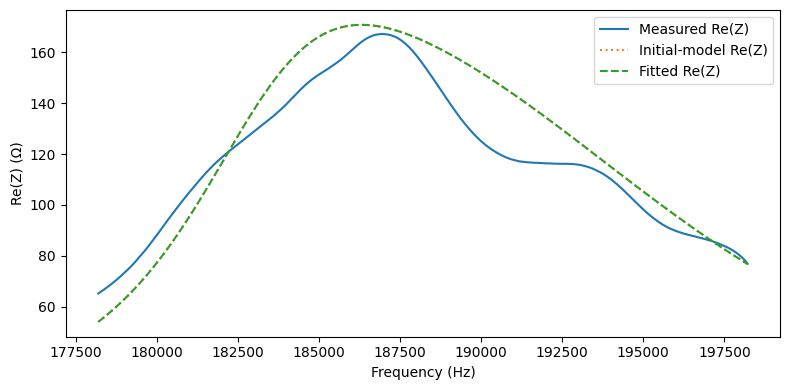

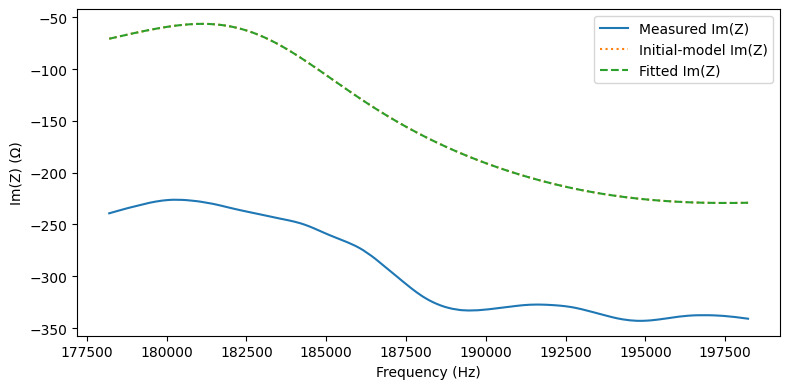


Derived fitted R/L/C:
R1 = 550, L1 = 0.00331154, C1 = 2.21098e-10, C01 = 2.5e-09
R2 = 150, L2 = 0.00311535, C2 = 2.51098e-10, C02 = 2.5e-09


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ------------------------
# YOUR measured data variables must already exist:
# f_fit (Hz), Z_meas_fit (complex)
f_fit = f_fit
Z_meas = Z_meas_fit_healthy
# ------------------------

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    """Given R, L, C (motional C), and C0, return fs (Hz), Q, Cm, C0"""
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- Two-DOF model using theta = [fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02] ---
def TwoDOF_bvd_theta(f, theta):
    fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02 = theta
    # convert to R,L,C
    R1, L1, C1, C01 = RLC_from_fsQCm(fs1, Q1, Cm1, C01)
    R2, L2, C2, C02 = RLC_from_fsQCm(fs2, Q2, Cm2, C02)

    w = 2*np.pi*f
    Z1 = R1 + 1j*w*L1 + 1.0/(1j*w*C1)
    Y1 = 1j*w*C01 + 1.0/Z1
    Z2 = R2 + 1j*w*L2 + 1.0/(1j*w*C2)
    Y2 = 1j*w*C02 + 1.0/Z2
    return 1.0 / (Y1 + Y2)

# --- weighted residuals ---
def residuals_theta(theta, f, Z_meas, peak_guesses=None, w_real=5.0, w_imag=1.0):
    Z_model = TwoDOF_bvd_theta(f, theta)

    # frequency weights (sum of Gaussians)
    W = np.ones_like(f, dtype=float)
    if peak_guesses is not None:
        for fc in peak_guesses:
            sigma = 0.03 * fc  # tightened to 3% band by default
            W += np.exp(-0.5*((f - fc)/sigma)**2)

    # scale each channel by robust scale (median abs)
    sR = np.median(np.abs(Z_meas.real)) + 1e-12
    sI = np.median(np.abs(Z_meas.imag)) + 1e-12

    rR = w_real * W * (Z_model.real - Z_meas.real) / sR
    rI = w_imag * W * (Z_model.imag - Z_meas.imag) / sI
    return np.concatenate([rR, rI])

# -------------------------
# Use your original R/L/C initial values to produce initial theta
# (these came from your message)
R1 = 550
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 150
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9

# compute fs, Q, Cm from those
fs1_guess, Q1_guess, Cm1_guess, C01_guess = bvd_from_RLC(R1, L1, C1, C0_1)
fs2_guess, Q2_guess, Cm2_guess, C02_guess = bvd_from_RLC(R2, L2, C2, C0_2)

print("Derived initial guesses from your R,L,C:")
print(f"fs1 = {fs1_guess:.3f} Hz, Q1 = {Q1_guess:.3f}, Cm1 = {Cm1_guess:.3e}, C01 = {C01_guess:.3e}")
print(f"fs2 = {fs2_guess:.3f} Hz, Q2 = {Q2_guess:.3f}, Cm2 = {Cm2_guess:.3e}, C02 = {C02_guess:.3e}")

initial_theta = [fs1_guess, Q1_guess, Cm1_guess, C01_guess,
                 fs2_guess, Q2_guess, Cm2_guess, C02_guess]

# sensible bounds around these derived values
fs_pad = 0.15  # ±15% on frequency
lower = [
    (1-fs_pad)*fs1_guess, 1e-1, 1e-14, max(1e-13, C01_guess*0.1),
    (1-fs_pad)*fs2_guess, 1e-1, 1e-14, max(1e-13, C02_guess*0.1)
]
upper = [
    (1+fs_pad)*fs1_guess, 1e5, Cm1_guess*1e3, C01_guess*1e2,
    (1+fs_pad)*fs2_guess, 1e5, Cm2_guess*1e3, C02_guess*1e2
]

print("\nInitial theta and bounds:")
print("initial_theta =", initial_theta)
print("lower =", lower)
print("upper =", upper)

# Quick check: show how close initial model is to data (cost-like simple metric)
Z_init = TwoDOF_bvd_theta(f_fit, initial_theta)
init_err = np.mean(np.abs(Z_init - Z_meas))
print(f"\nInitial mean abs error (model vs measured): {init_err:.6e}")

# Now run the fit
result = least_squares(
    residuals_theta,
    initial_theta,
    args=(f_fit, Z_meas, [fs1_guess, fs2_guess], 5.0, 1.0),
    bounds=(lower, upper),
    method="trf",
    loss="soft_l1",
    ftol=1e-12, xtol=1e-12, gtol=1e-12,
    max_nfev=20000,
    verbose=2
)

print("\nFit cost:", result.cost)
labels = ["fs1","Q1","Cm1","C01","fs2","Q2","Cm2","C02"]
for name, val in zip(labels, result.x):
    print(f"{name} = {val}")

# Evaluate fitted model
Z_fit = TwoDOF_bvd_theta(f_fit, result.x)

# Plot measured vs fitted (real & imag)
plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.real, label="Measured Re(Z)")
plt.plot(f_fit, Z_init.real, ':', label="Initial-model Re(Z)")
plt.plot(f_fit, Z_fit.real, '--', label="Fitted Re(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Re(Z) (Ω)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.imag, label="Measured Im(Z)")
plt.plot(f_fit, Z_init.imag, ':', label="Initial-model Im(Z)")
plt.plot(f_fit, Z_fit.imag, '--', label="Fitted Im(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Im(Z) (Ω)")
plt.tight_layout(); plt.show()

# Print derived R,L from fitted params for interpretability
fs1_f, Q1_f, Cm1_f, C01_f, fs2_f, Q2_f, Cm2_f, C02_f = result.x
R1_f, L1_f, C1_f, _ = RLC_from_fsQCm(fs1_f, Q1_f, Cm1_f, C01_f)
R2_f, L2_f, C2_f, _ = RLC_from_fsQCm(fs2_f, Q2_f, Cm2_f, C02_f)
print("\nDerived fitted R/L/C:")
print(f"R1 = {R1_f:.6g}, L1 = {L1_f:.6g}, C1 = {C1_f:.6g}, C01 = {C01_f:.6g}")
print(f"R2 = {R2_f:.6g}, L2 = {L2_f:.6g}, C2 = {C2_f:.6g}, C02 = {C02_f:.6g}")
